### Multi-omic Dataset: Latent representation using Denoising Autoencoders
- Load Data
- Add Swap Noise to Data
- Normalize Data
- Define Autoencoder Model
- Train Autoencoder with normalized noisy dataset
- Use transformed dataset for classification
- Use transformed dataset for clustering
- Evaluation and Conclusions

In [1]:
import Models
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

X_train_norm, X_train_swapped, X_test_norm, y_train, y_test, y_train_oh, y_test_oh, X_train_first, X_train_second, X_swapped_first, X_swapped_second, X_test_first, X_test_second \
    = Models.prepare_datasets(X_renal_data.iloc[:,1:],y_renal_data["label"], test_size=0.2, swap_noise=0.15)

# We will use "X_train_swapped" as input training dataset and "X_train_norm" as output for the loss function of the Denoising Autoencoder

swapping: 65 rows.


In [ ]:
import importlib
importlib.reload(Models)

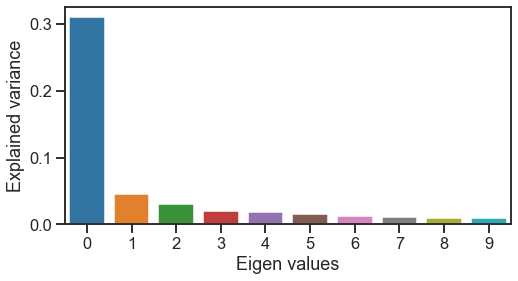

PCA on single-modal explained variance ratio: 0.48103795292302987


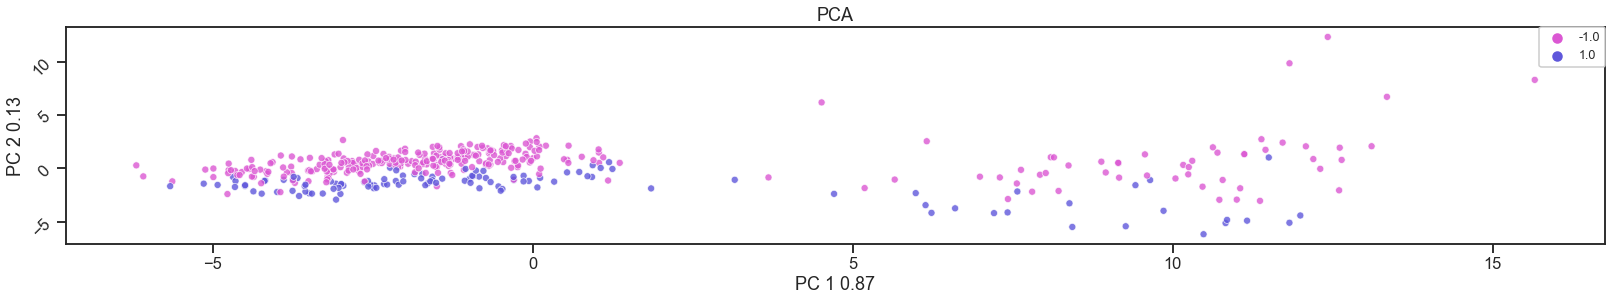

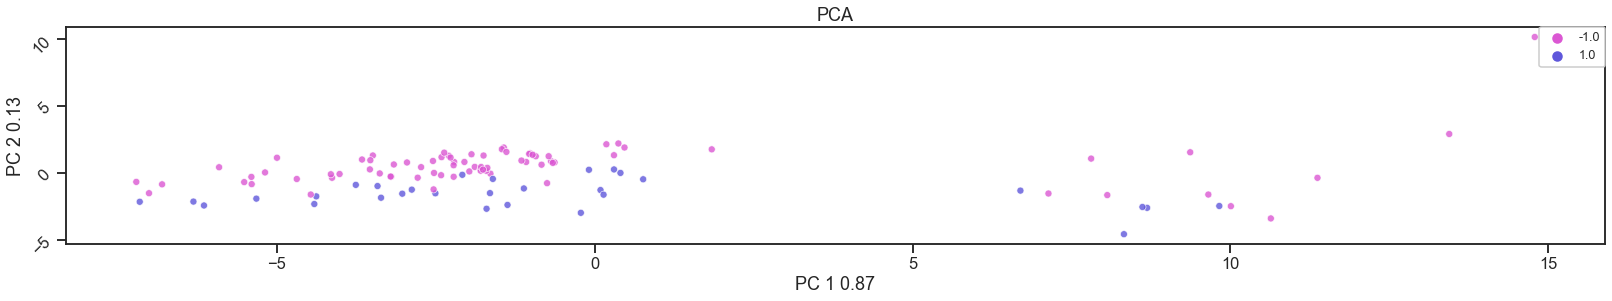

Compression: 102.52
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5126)]            0         
_________________________________________________________________
encoder (Model)              (None, 50)                2070850   
_________________________________________________________________
model (Model)                (None, 5126)              2076126   
Total params: 4,146,976
Trainable params: 4,146,876
Non-trainable params: 100
_________________________________________________________________


KeyboardInterrupt: 

In [2]:
###  Hyperparamter tuning
# MAP y_train from classes -1 and 1 to 0 and 1
y_train_map = ((y_train + 1)/2).astype(int)

### VISUALIZATION WITH PCA
## ORIGINAL DATASET
X_latent_pca, X_latent_test_pca = Models.perform_PCA(X_train_norm, X_test_norm, y_train, y_test, n_components=10)

dropouts = [0,0.1,0.2,0.3]
l1s = [0,0.000005]
l2s = [0,0.000005]
scores = []
for dropout in dropouts:
    for l1 in l1s:
        for l2 in l2s:
            ## Build and Train Autoencoder
            autoencoder, encoder, decoder, loss = Models.build_and_train_autoencoder(X_train_swapped,
                                                                          X_train_norm,
                                                                          encoding_dim=50, 
                                                                          regularizer=tf.keras.regularizers.l1_l2(l1,l2),
                                                                          dropout=dropout,
                                                                          epochs=200)
            ## Encode datasets
            X_latent_ae = Models.encode_dataset(X_train_norm, encoder)
            X_latent_test_ae = Models.encode_dataset(X_test_norm, encoder)
         
            ## PCA ON AUTOENCODER LATENT SPACE
            X_latent_pca_ae, X_latent_test_pca_ae = Models.perform_PCA(X_latent_ae, X_latent_test_ae, y_train, y_test, n_components=10)

            ### CLASSIFICATION ###
            # We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.
            lr_accuracy, svm_accuracy, rf_accuracy = Models.classify(X_latent_ae, X_latent_test_ae, y_train, y_test, model_type="AE")

            ### CLUSTERING ###
            silhouette_kmeans, mutual_info_kmeans, silhouette_spectral, mutual_info_spectral, silhouette_hierarchical, mutual_info_hierarchical = Models.cluster(X_latent_ae,y_train_map, model_type="AE")

            scores.append((dropout,l1,l2,loss,lr_accuracy,svm_accuracy,rf_accuracy,silhouette_kmeans, mutual_info_kmeans, silhouette_spectral, mutual_info_spectral, silhouette_hierarchical, mutual_info_hierarchical))


In [10]:
### CLASSIFICATION ###
# We use the reduced dataset to train a classifier and compare it against the same classifier trained with the original dataset.

# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

## Definition of the best classifier obtained previously (CTG_dataset_classification)
def build_best_model(dropout: int, l1: int, l2: int, input_shape: int):
    model = keras.Sequential([
        layers.Dense(30, activation=tf.nn.relu ,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=(input_shape,)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(10,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(5,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(2,activation=tf.nn.softmax)
      ])

    optimizer = tf.keras.optimizers.Adam(0.01)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model


# Fit best model with dimensionality reduction data
model_ae = build_best_model(0.5,0.0001, 0.0001, X_train_encoded.shape[1])
history_ae = model_ae.fit(X_train_encoded, y_train_oh, epochs=400,
                    validation_split = 0.1, verbose=1, callbacks=[], shuffle=False)
hist_ae = pd.DataFrame(history_ae.history)

test_loss, test_acc = model_ae.evaluate(X_test_encoded, y_test_oh)

# Fit best model with concatenated data
#model = build_best_model(0.5,0.0001,0.0001, X_train_norm.shape[1])
#history = model.fit(X_train, y_train_oh, epochs=150,
#                    validation_split = 0.1, verbose=1, callbacks=[early_stop])
#hist = pd.DataFrame(history.history)

#test_loss, test_acc = model.evaluate(X_test, y_test_oh)

Train on 389 samples, validate on 44 samples
Epoch 1/400
389/389 [==============================] - 1s 2ms/sample - loss: 1.0320 - accuracy: 0.5707 - val_loss: 0.8316 - val_accuracy: 0.6591
Epoch 2/400
389/389 [==============================] - 0s 80us/sample - loss: 0.8507 - accuracy: 0.6607 - val_loss: 0.7972 - val_accuracy: 0.6591
Epoch 3/400
389/389 [==============================] - 0s 80us/sample - loss: 0.7807 - accuracy: 0.6967 - val_loss: 0.7886 - val_accuracy: 0.6591
Epoch 4/400
389/389 [==============================] - 0s 80us/sample - loss: 0.7179 - accuracy: 0.7378 - val_loss: 0.7845 - val_accuracy: 0.6591
Epoch 5/400
389/389 [==============================] - 0s 120us/sample - loss: 0.7067 - accuracy: 0.7378 - val_loss: 0.7794 - val_accuracy: 0.6591
Epoch 6/400
389/389 [==============================] - 0s 80us/sample - loss: 0.6978 - accuracy: 0.7404 - val_loss: 0.7693 - val_accuracy: 0.6591
Epoch 7/400
389/389 [==============================] - 0s 121us/sample - loss: 

In [17]:
scores = pd.DataFrame(scores,
                      columns=["dropout","l1","l2","loss","LR_accuracy","SVM_accuracy", "RF_accuracy","kmeans_silhouette","kmeans_mutual_info","spectral_silhouette","spectral_mutual_info","hierarchical_silhouette","hierarchical_mutual_info"])    
scores

,dropout,l1,l2,loss,LR_accuracy,SVM_accuracy,RF_accuracy,kmeans_silhouette,kmeans_mutual_info,spectral_silhouette,spectral_mutual_info,hierarchical_silhouette,hierarchical_mutual_info
0,0.0,0.000000,0.000000,0.006234,0.954128,0.880734,0.954128,0.406828,0.000334,0.409936,0.001123,0.407743,0.000334
1,0.0,0.000000,0.000005,0.006297,0.954128,0.908257,0.963303,0.391209,0.000484,0.383251,0.001123,0.388842,0.000070
2,0.0,0.000005,0.000000,0.010156,0.963303,0.944954,0.935780,0.473726,0.000665,0.467783,0.004437,0.474153,0.000878
3,0.0,0.000005,0.000005,0.010877,0.944954,0.954128,0.963303,0.494446,0.000878,0.494534,0.001402,0.489692,0.001402
4,0.1,0.000000,0.000000,0.006357,0.935780,0.816514,0.963303,0.392492,0.000334,0.401865,0.000490,0.392492,0.000334
5,0.1,0.000000,0.000005,0.007520,0.944954,0.816514,0.963303,0.396170,0.001006,0.401090,0.006027,0.392720,0.000484
6,0.1,0.000005,0.000000,0.009498,0.944954,0.926606,0.935780,0.500796,0.000878,0.558838,0.004701,0.497361,0.000484
7,0.1,0.000005,0.000005,0.011452,0.944954,0.944954,0.963303,0.500695,0.001262,0.502584,0.001123,0.500626,0.000484
8,0.2,0.000000,0.000000,0.008108,0.954128,0.889908,0.972477,0.416686,0.000484,0.417687,0.000115,0.416564,0.000334
9,0.2,0.000000,0.000005,0.008473,0.954128,0.798165,0.944954,0.385785,0.000484,0.544972,0.004701,0.383943,0.000334


### RESULTS 

| Encoding dim | l1      | l2      | Dropout | Loss   | Accuracy (LR) | Accuracy (SVM) | Accuracy (RF) | SS (K-means) | MI (K-means) | SS (Spectral) | MI (Spectral) | SS (Hierarchical) | MI (Hierarchical) |
|--------------|---------|---------|---------|--------|---------------|----------------|---------------|--------------|--------------|---------------|---------------|-------------------|-------------------|
| 50           | 0.000005| 0.000005| 0.00    | 0.0108 |  0.94         | 0.95           | 0.96          | 0.49         | 0.0008       | 0.49          | 0.0014        | 0.48              | 0.0014            |
| 50           | 0.000001| 0.000005| 0.01    | 0.0113 |  0.95         | 0.96           | 0.95          | 0.43         | 0.4320       | 0.46          | 0.0007        | 0.43              | 0.4240            |
| 50           | 0       | 0.000005| 0.05    | 0.0107 |  0.93         | 0.92           | 0.93          | 0.41         | 0.4271       | 0.40          | 0.2424        | 0.41              | 0.4273            |
| 50           | 0.000001| 0.000005| 0.05    | 0.0107 |  0.78         | 0.84           | 0.95          | 0.33         | 0.0083       | 0.47          | 0.0014        | 0.47              | 0.0004            |
| 50           | 0       | 0.000005| 0.10    | 0.0114 |  0.96         | 0.95           | 0.95          | 0.52         | 0.4585       | 0.52          | 0.4628        | 0.52              | 0.4585            |
| 50           | 0.000001| 0.000005| 0.10    | 0.0119 |  0.95         | 0.97           | 0.96          | 0.55         | 0.4805       | 0.55          | 0.4441        | 0.55              | 0.4441            |
| 50           | 0.000001| 0.000005| 0.15    | 0.0119 |  0.96         | 0.96           | 0.96          | 0.52         | 0.4653       | 0.52          | 0.4695        | 0.5167            | 0.4542            |
| 50           | 0       | 0.000005| 0.20    | 0.0111 |  0.96         | 0.95           | 0.97          | 0.40         | 0.1469       | 0.43          | 0.0003        | 0.43              | 0.0008            |
|--------------|---------|---------|---------|--------|---------------|----------------|---------------|--------------|--------------|---------------|---------------|-------------------|-------------------|
| 100          | 0.000005| 0.000005| 0.15    | 0.0149 |  0.96         | 0.96           | 0.96          | 0.49         | 0.4671       | 0.48          | 0.0006        | 0.49              | 0.4585            |
| 100          | 0       | 0.000005| 0.20    | 0.0111 |  0.96         | 0.94           | 0.97          | 0.49         | 0.4398       | 0.45          | 0.0001        | 0.49              | 0.4083            |
|--------------|---------|---------|---------|--------|---------------|----------------|---------------|--------------|--------------|---------------|---------------|-------------------|-------------------|
| 200          | 0       | 0       | 0.15    | 0.0093 |  0.97         | 0.98           | 0.97          | 0.41         | 0.4398       | 0.39          | 0.0003        | 0.39              | 0.4335            |
| 200          | 0       | 0.000005| 0.25    | 0.0113 |  0.97         | 0.98           | 0.97          | 0.46         | 0.4487       | 0.42          | 0.0004        | 0.46              | 0.4398            |
| 200          | 0.000005| 0       | 0.20    | 0.0149 |  0.96         | 0.96           | 0.96          | 0.51         | 0.4359       | 0.51          | 0.0018        | 0.50              | 0.4628            |
|--------------|---------|---------|---------|--------|---------------|----------------|---------------|--------------|--------------|---------------|---------------|-------------------|-------------------|
| 20           | 0.000005| 0       | 0.10    | 0.0112 |  0.97         | 0.97           | 0.93          | 0.56         | 0.4412       | 0.56          | 0.4490        | 0.55              | 0.4611            |
|--------------|---------|---------|---------|--------|---------------|----------------|---------------|--------------|--------------|---------------|---------------|-------------------|-------------------|
| 500          | 0       | 0.000005| 0.10    | 0.0073 |  0.97         | 0.86           | 0.98          | 0.41         | 0.0010       | 0.41          | 0.0004        | 0.41              | 0.0003            |



### Conclusion
Here we trained an autoencoder using a dataset modified with noise, and used the original dataset to force the autoencoder to reconstruct it from a smaller latent space. This lead to a latent space of about 1000 times smaller than the original. When compared using classifiers and clustering methods, there is a drop in accuracy and a significant increase in silhouette score. The dimensionality reduction speeds the classifier training process and enables the training of more complex models in reduced amount of time.

Classifier Accuracy:

Silhouette Score: 0.8439
